# Gauge Function Approach for PINNs

### Enforcing Constraints in Physics-Informed Neural Networks

When solving partial differential equations (PDEs) using Physics-Informed Neural Networks (PINNs), a crucial aspect is satisfying the initial conditions (ICs) and boundary conditions (BCs) of the problem.

#### Traditional PINN Approach: Soft Constraints

The standard approach in many PINN implementations is to treat ICs and BCs as "soft constraints." This involves:
1.  A neural network `NN(x,t; θ)` that directly approximates the solution `u(x,t)`.
2.  A composite loss function that includes:
    *   **PDE Residual Loss (`MSE_f`):** Measures how well the network's output satisfies the PDE at a set of collocation points within the domain.
    *   **IC/BC Loss (`MSE_u`):** Measures the discrepancy between the network's output and the known values at the initial time and on the domain boundaries.
    ```
    Total Loss = w_f * MSE_f + w_u * MSE_u
    ```
3.  The network is trained by minimizing this total loss. The weights `w_f` and `w_u` are hyperparameters that balance the importance of satisfying the PDE versus the ICs/BCs.

**Drawbacks:**
*   The satisfaction of ICs/BCs is not guaranteed to be exact, as it depends on the optimization process and the chosen weights.
*   Finding appropriate loss weights can require extensive hyperparameter tuning.

#### Gauge Function Approach: Hard Constraint Enforcement

The "gauge function" method, also known as using a "solution ansatz," offers a way to enforce ICs and BCs as "hard constraints." The core idea is to design the output structure of the neural network such that it *inherently* or *by construction* satisfies these conditions.

**1. Constructing the Solution Ansatz:**
Instead of the neural network directly outputting `u(x,t)`, it outputs an unconstrained function, say `NN_output(x_scaled, t_scaled; θ)`. This output is then used as part of a carefully constructed analytical expression, `u_gauge(x,t)`, which is designed to automatically satisfy all ICs and BCs, regardless of the values produced by `NN_output`.

For the 1D Burger's equation problem with:
*   IC: `u(x, 0) = -sin(πx)`
*   BCs: `u(-1, t) = 0` and `u(1, t) = 0`

A suitable gauge function (ansatz) is:
```
u_gauge(x, t) = -sin(πx) + t * (1 - x^2) * NN_output(x_scaled, t_scaled; θ)
```
Where `x_scaled, t_scaled` are typically feature-scaled versions of `x, t` (e.g., mapped to `[-1, 1]`) fed into the neural network.

**2. Verification of Constraint Satisfaction:**
*   **Initial Condition (t=0):**
    `u_gauge(x, 0) = -sin(πx) + 0 * (1 - x^2) * NN_output = -sin(πx)`
    The IC is satisfied.
*   **Boundary Condition (x=-1):**
    `u_gauge(-1, t) = -sin(-π) + t * (1 - (-1)^2) * NN_output = 0 + t * (1 - 1) * NN_output = 0`
    The BC at `x=-1` is satisfied.
*   **Boundary Condition (x=1):**
    `u_gauge(1, t) = -sin(π) + t * (1 - (1)^2) * NN_output = 0 + t * (1 - 1) * NN_output = 0`
    The BC at `x=1` is satisfied.

**3. Role of the Neural Network:**
With the ICs/BCs structurally enforced, the neural network `NN_output` is now responsible for learning the remaining part of the solution behavior such that the *entire* `u_gauge(x,t)` satisfies the Burger's PDE:
`∂u_gauge/∂t + u_gauge * ∂u_gauge/∂x - ν * ∂²u_gauge/∂x² = 0`

**4. Loss Function:**
The training loss function for the gauge-constrained PINN simplifies significantly. It only needs to contain the PDE residual term, as the IC/BC satisfaction is built into the architecture:
```
Total Loss = MSE_f  (calculated using u_gauge and its derivatives)
```

**5. Relation to "Reconstruction Function":**
The concept of a "reconstruction function," as sometimes discussed in contexts like the LOOP framework for optimization proxies, generally refers to a mechanism that ensures an output (e.g., from a primary neural network) adheres to certain (often equality) constraints. This might be a post-processing step or an integrated differentiable layer.

The gauge function approach is a specific, problem-dependent way of achieving such constraint satisfaction *a priori*.
*   It **constructs** the solution form to be valid from the outset, particularly for Dirichlet-type conditions on ICs/BCs.
*   Instead of the network learning an unconstrained solution and then having a separate module "reconstruct" it to be feasible, the gauge function defines the *space of feasible functions* (with respect to IC/BCs) from which the PINN effectively selects by learning `NN_output`.
*   So, the gauge function itself acts as the "reconstruction" by defining how `NN_output` contributes to the final, constrained solution `u_gauge`. It's a direct analytical imposition of the solution's structure at the boundaries and initial time.

**Advantages of the Gauge Function Approach:**
*   **Exact IC/BC Satisfaction:** The specified conditions are met by the mathematical form of `u_gauge` (up to the numerical precision of floating-point arithmetic).
*   **Simplified Loss Function:** No need for IC/BC loss terms, removing the associated hyperparameters (loss weights `w_u`).
*   **Focused Learning Task:** The neural network can concentrate on learning the dynamics of the PDE in the interior of the domain, as it's freed from also having to learn the boundary behavior through penalty terms.
*   **Potentially More Stable Training:** Reducing the complexity of the loss landscape and the number of competing objectives can lead to more stable and efficient training.

**Limitations and Considerations:**
*   **Deriving the Ansatz:** The main challenge is devising an appropriate gauge function. This can be straightforward for simple geometries and conditions but becomes significantly more complex for irregular domains, complex boundary shapes, or non-Dirichlet boundary conditions (e.g., Neumann, Robin).
*   **Solution Space Restriction:** While the `NN_output` term provides flexibility, a poorly chosen ansatz might overly restrict the space of possible solutions, potentially preventing the network from finding the true PDE solution if it doesn't conform well to the ansatz structure. However, for many common problems, effective ansatz forms are known or can be derived.

In summary, the gauge function method provides a powerful way to incorporate known initial and boundary information directly into the PINN's solution structure, leading to more robust and accurate satisfaction of these essential constraints.

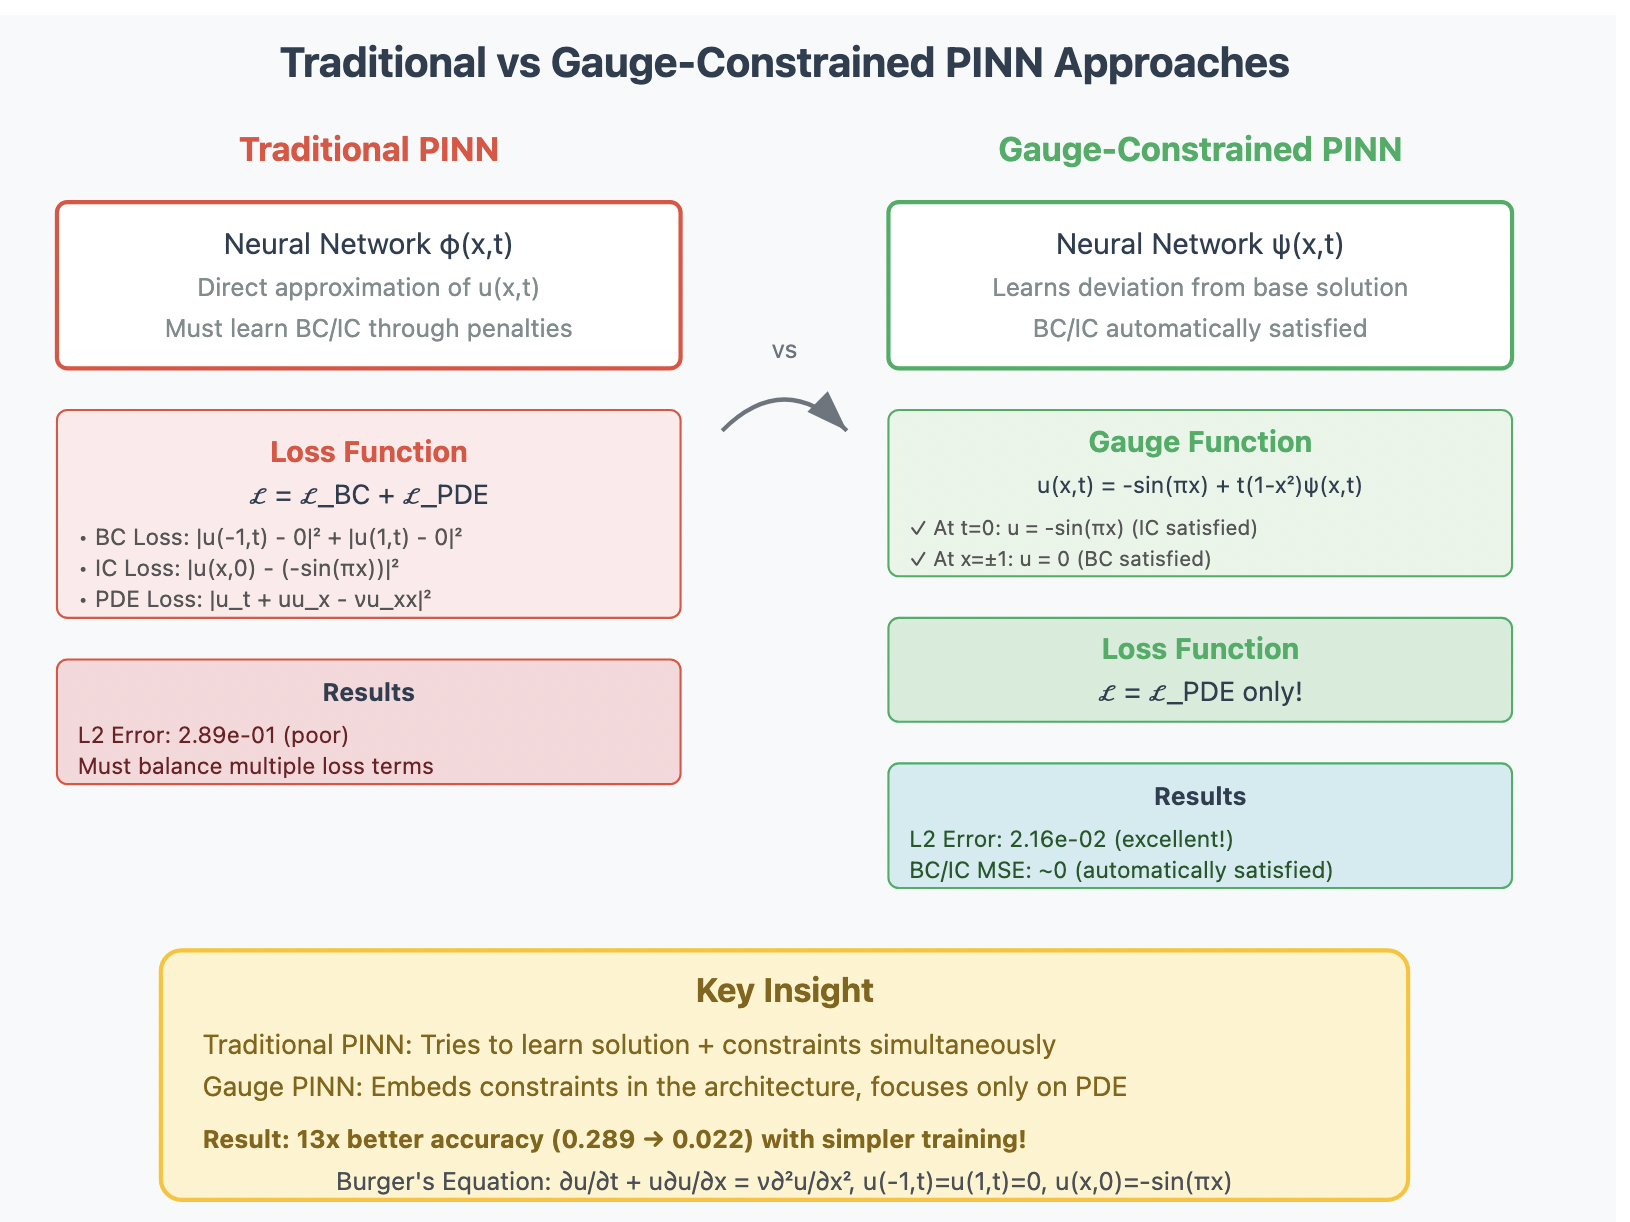

Using device: cpu

--- Training Traditional Burger PINN ---


Training Traditional PINN: 100%|██████████| 3000/3000 [01:35<00:00, 31.52it/s, Loss=7.10e-03, BC=3.30e-03, PDE=3.81e-03]


Final Traditional: Loss=7.1039e-03, BC_Loss=3.2976e-03, PDE_Loss=3.8063e-03

--- Training Gauge-Constrained Burger PINN ---


Training Gauge PINN: 100%|██████████| 3000/3000 [01:43<00:00, 28.94it/s, Loss=2.48e-03 (PDE Loss)]


Final Gauge: Loss=2.4778e-03 (PDE Loss)

L2 Relative Error (Traditional): 2.8850e-01
L2 Relative Error (Gauge): 2.1583e-02
Gauge PINN IC MSE: 0.00e+00
Gauge PINN BC (u(-1,t)=0, u(1,t)=0) MSE: 1.53e-14


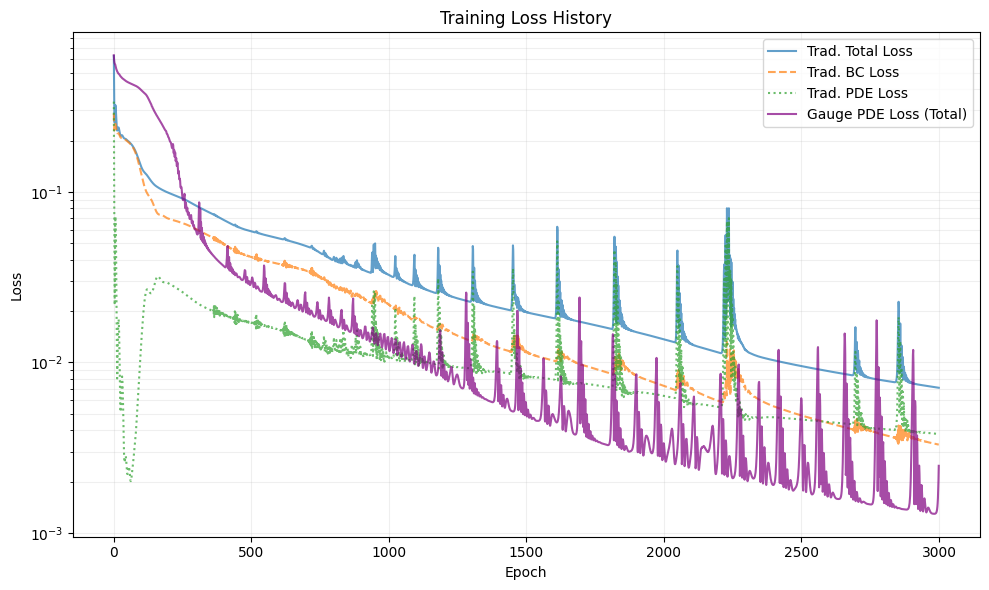

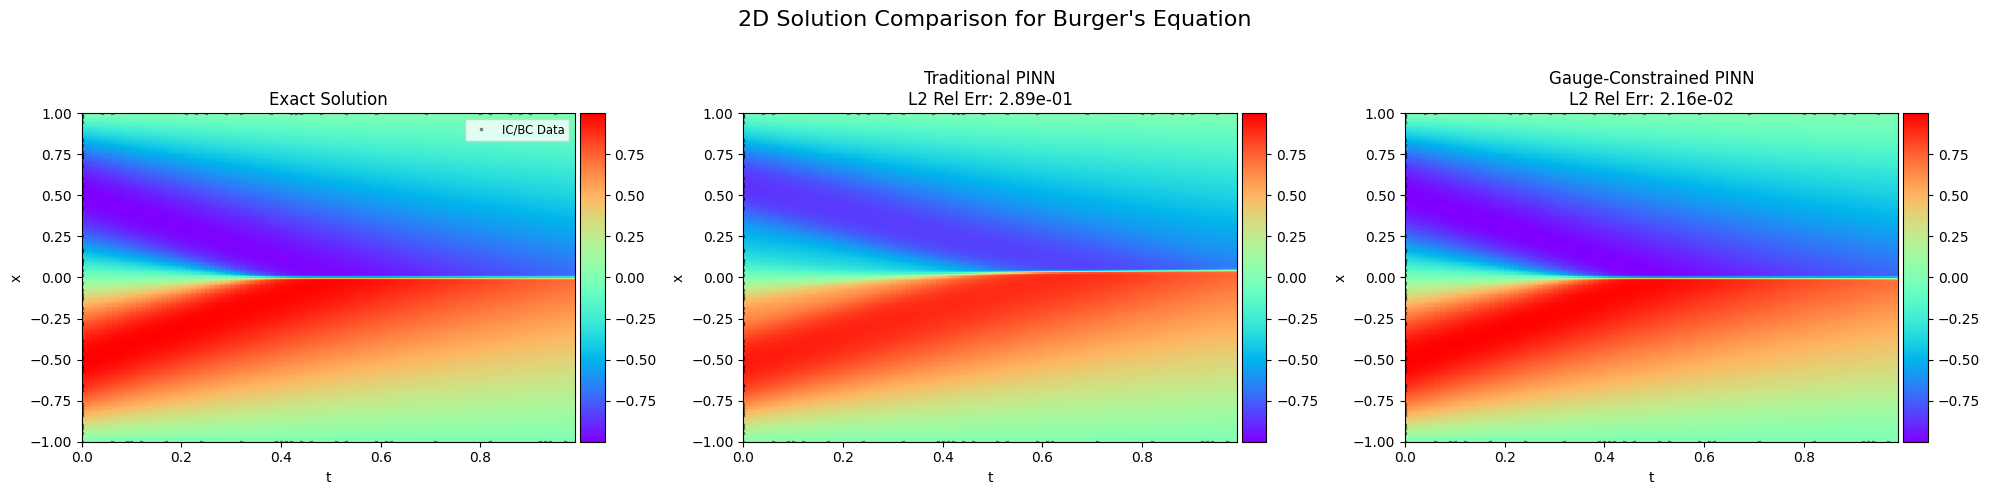

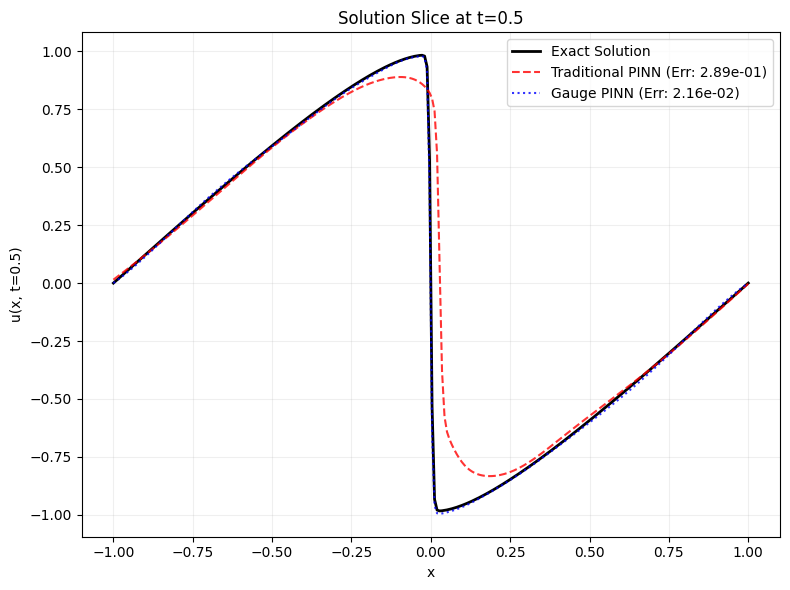

In [5]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import numpy as np
import math
import time
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyDOE import lhs # For Latin Hypercube Sampling
from tqdm import tqdm # Import tqdm


# --- Setup from Notebook ---
torch.set_default_dtype(torch.float)
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

nu_val = 0.01 / np.pi

# --- Traditional FCN PINN (adapted from notebook for clarity) ---
class TraditionalBurgerPINN(nn.Module):
    def __init__(self, layers, lb, ub):
        super().__init__()
        self.activation = nn.Tanh()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.lb = torch.tensor(lb, dtype=torch.float).to(device)
        self.ub = torch.tensor(ub, dtype=torch.float).to(device)
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
        self.loss_history_total = []
        self.loss_history_bc = []
        self.loss_history_pde = []

    def forward(self, X_xt):
        if not torch.is_tensor(X_xt):
            X_xt = torch.from_numpy(X_xt).float().to(device)
        X_scaled = 2.0 * (X_xt - self.lb) / (self.ub - self.lb) - 1.0
        a = X_scaled
        for i in range(len(self.linears) - 1):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    def loss_BC(self, X_train_Nu, U_train_Nu):
        u_pred = self.forward(X_train_Nu)
        loss_u = torch.mean((u_pred - U_train_Nu)**2)
        return loss_u

    def loss_PDE(self, X_train_Nf, nu_coeff):
        g = X_train_Nf.clone()
        g.requires_grad = True
        u = self.forward(g)
        u_xt = autograd.grad(u, g, torch.ones_like(u).to(device), create_graph=True)[0]
        u_x = u_xt[:, 0:1]
        u_t = u_xt[:, 1:2]
        u_x_grad_output = autograd.grad(u_x, g, torch.ones_like(u_x).to(device), create_graph=True)[0] # For u_xx
        u_xx = u_x_grad_output[:, 0:1]
        f = u_t + u * u_x - nu_coeff * u_xx
        loss_f = torch.mean(f**2)
        return loss_f

    def train_model(self, X_train_Nu, U_train_Nu, X_train_Nf, nu_coeff, epochs, optimizer, pbar_desc="Traditional"):
        self.train()
        pbar = tqdm(range(epochs), desc=f"Training {pbar_desc} PINN")
        for epoch in pbar:
            optimizer.zero_grad()
            l_bc = self.loss_BC(X_train_Nu, U_train_Nu)
            l_pde = self.loss_PDE(X_train_Nf, nu_coeff)
            loss = l_bc + l_pde
            loss.backward()
            optimizer.step()
            self.loss_history_total.append(loss.item())
            self.loss_history_bc.append(l_bc.item())
            self.loss_history_pde.append(l_pde.item())
            if epoch % 100 == 0 or epoch == epochs -1 :
                 pbar.set_postfix_str(f"Loss={loss.item():.2e}, BC={l_bc.item():.2e}, PDE={l_pde.item():.2e}")
        print(f"Final {pbar_desc}: Loss={self.loss_history_total[-1]:.4e}, BC_Loss={self.loss_history_bc[-1]:.4e}, PDE_Loss={self.loss_history_pde[-1]:.4e}")

# --- Gauge-Constrained PINN for Burger's Equation ---
class GaugeBurgerPINN(nn.Module):
    def __init__(self, layers, lb, ub):
        super().__init__()
        self.activation = nn.Tanh()
        self.dnn_unconstrained = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.lb = torch.tensor(lb, dtype=torch.float).to(device)
        self.ub = torch.tensor(ub, dtype=torch.float).to(device)
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.dnn_unconstrained[i].weight.data, gain=1.0)
            nn.init.zeros_(self.dnn_unconstrained[i].bias.data)
        self.loss_history_total = []
        self.loss_history_pde = []

    def forward(self, X_xt_unscaled):
        if not torch.is_tensor(X_xt_unscaled):
            X_xt_unscaled = torch.from_numpy(X_xt_unscaled).float().to(device)
        x_orig = X_xt_unscaled[:, 0:1]
        t_orig = X_xt_unscaled[:, 1:2]
        X_xt_scaled = 2.0 * (X_xt_unscaled - self.lb) / (self.ub - self.lb) - 1.0
        a = X_xt_scaled
        for i in range(len(self.dnn_unconstrained) - 1):
            z = self.dnn_unconstrained[i](a)
            a = self.activation(z)
        nn_out = self.dnn_unconstrained[-1](a)
        pi_tensor = torch.tensor(math.pi, dtype=torch.float, device=device)
        u_gauge = -torch.sin(pi_tensor * x_orig) + \
                    t_orig * (1 - x_orig**2) * nn_out # Corrected: (1 - x_orig**2)
        return u_gauge

    def loss_PDE(self, X_train_Nf_unscaled, nu_coeff):
        g = X_train_Nf_unscaled.clone()
        g.requires_grad = True
        u = self.forward(g)
        u_xt = autograd.grad(u, g, torch.ones_like(u).to(device), create_graph=True)[0]
        u_x = u_xt[:, 0:1]
        u_t = u_xt[:, 1:2]
        u_x_grad_output = autograd.grad(u_x, g, torch.ones_like(u_x).to(device), create_graph=True)[0]
        u_xx = u_x_grad_output[:, 0:1]
        f_residual = u_t + u * u_x - nu_coeff * u_xx
        loss_f = torch.mean(f_residual**2)
        return loss_f

    def train_model(self, X_train_Nf_unscaled, nu_coeff, epochs, optimizer, pbar_desc="Gauge"):
        self.train()
        pbar = tqdm(range(epochs), desc=f"Training {pbar_desc} PINN")
        for epoch in pbar:
            optimizer.zero_grad()
            l_pde = self.loss_PDE(X_train_Nf_unscaled, nu_coeff)
            loss = l_pde
            loss.backward()
            optimizer.step()
            self.loss_history_total.append(loss.item())
            self.loss_history_pde.append(l_pde.item())
            if epoch % 100 == 0 or epoch == epochs -1:
                pbar.set_postfix_str(f"Loss={loss.item():.2e} (PDE Loss)")
        print(f"Final {pbar_desc}: Loss={self.loss_history_total[-1]:.4e} (PDE Loss)")

# --- Data Loading and Preparation (from notebook) ---
data = scipy.io.loadmat('burgers_shock.mat')
t_data_vec = data['t'].flatten() # Shape (100,)
x_data_vec = data['x'].flatten() # Shape (256,)
Exact_u_grid = np.real(data['usol']) # Shape (N_x, N_t) = (256, 100)

X_mesh, T_mesh = np.meshgrid(x_data_vec, t_data_vec, indexing='ij') # N_x x N_t
X_test_np = np.hstack((X_mesh.flatten()[:,None], T_mesh.flatten()[:,None]))
u_test_np = Exact_u_grid.flatten()[:,None]

lb_domain = X_test_np.min(axis=0)
ub_domain = X_test_np.max(axis=0)

X_ic = np.hstack((x_data_vec[:,None], np.zeros((x_data_vec.shape[0], 1))))
U_ic = -np.sin(np.pi * x_data_vec[:,None])
X_bc1 = np.hstack((np.full((t_data_vec.shape[0],1), -1.0), t_data_vec[:,None]))
U_bc1 = np.zeros((t_data_vec.shape[0],1))
X_bc2 = np.hstack((np.full((t_data_vec.shape[0],1), 1.0), t_data_vec[:,None]))
U_bc2 = np.zeros((t_data_vec.shape[0],1))
X_train_Nu_np = np.vstack([X_ic, X_bc1, X_bc2])
U_train_Nu_np = np.vstack([U_ic, U_bc1, U_bc2])

N_u_notebook = 100
idx_Nu = np.random.choice(X_train_Nu_np.shape[0], N_u_notebook, replace=False)
X_train_Nu_sampled_np = X_train_Nu_np[idx_Nu, :]
U_train_Nu_sampled_np = U_train_Nu_np[idx_Nu, :]

N_f_notebook = 10000
X_train_Nf_unscaled_np = lb_domain + (ub_domain - lb_domain) * lhs(2, N_f_notebook)
X_train_Nf_traditional_np = np.vstack((X_train_Nf_unscaled_np, X_train_Nu_sampled_np))

X_train_Nu_sampled = torch.from_numpy(X_train_Nu_sampled_np).float().to(device)
U_train_Nu_sampled = torch.from_numpy(U_train_Nu_sampled_np).float().to(device)
X_train_Nf_traditional = torch.from_numpy(X_train_Nf_traditional_np).float().to(device)
X_train_Nf_unscaled = torch.from_numpy(X_train_Nf_unscaled_np).float().to(device)
X_test = torch.from_numpy(X_test_np).float().to(device)
u_test_true = torch.from_numpy(u_test_np).float().to(device)

# --- Model Initialization and Training ---
layers_nn = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
epochs_train = 3000 # Increased epochs for potentially better convergence
lr_train = 1e-3

print("\n--- Training Traditional Burger PINN ---")
traditional_pinn = TraditionalBurgerPINN(layers_nn, lb_domain, ub_domain).to(device)
optimizer_trad = torch.optim.Adam(traditional_pinn.parameters(), lr=lr_train)
traditional_pinn.train_model(X_train_Nu_sampled, U_train_Nu_sampled, X_train_Nf_traditional,
                             nu_val, epochs_train, optimizer_trad, pbar_desc="Traditional")

print("\n--- Training Gauge-Constrained Burger PINN ---")
gauge_pinn = GaugeBurgerPINN(layers_nn, lb_domain, ub_domain).to(device)
optimizer_gauge = torch.optim.Adam(gauge_pinn.parameters(), lr=lr_train)
gauge_pinn.train_model(X_train_Nf_unscaled, nu_val, epochs_train, optimizer_gauge, pbar_desc="Gauge")

# --- Evaluation ---
traditional_pinn.eval()
gauge_pinn.eval()
with torch.no_grad():
    u_pred_trad = traditional_pinn(X_test)
    u_pred_gauge = gauge_pinn(X_test)
error_trad = torch.linalg.norm(u_test_true - u_pred_trad) / torch.linalg.norm(u_test_true)
error_gauge = torch.linalg.norm(u_test_true - u_pred_gauge) / torch.linalg.norm(u_test_true)
print(f"\nL2 Relative Error (Traditional): {error_trad.item():.4e}")
print(f"L2 Relative Error (Gauge): {error_gauge.item():.4e}")

x_ic_check = torch.linspace(-1, 1, 100, device=device).float().unsqueeze(1)
t_ic_check = torch.zeros_like(x_ic_check, device=device).float()
Xt_ic_check = torch.hstack((x_ic_check, t_ic_check))
u_ic_gauge_pred = gauge_pinn(Xt_ic_check)
u_ic_true_check = -torch.sin(math.pi * x_ic_check)
ic_error_gauge = torch.mean((u_ic_gauge_pred - u_ic_true_check)**2)
print(f"Gauge PINN IC MSE: {ic_error_gauge.item():.2e}")

t_bc_check = torch.linspace(0, 1, 100, device=device).float().unsqueeze(1)
x_bc1_check = torch.full_like(t_bc_check, -1.0, device=device).float()
x_bc2_check = torch.full_like(t_bc_check, 1.0, device=device).float()
Xt_bc1_check = torch.hstack((x_bc1_check, t_bc_check))
Xt_bc2_check = torch.hstack((x_bc2_check, t_bc_check))
u_bc1_gauge_pred = gauge_pinn(Xt_bc1_check)
u_bc2_gauge_pred = gauge_pinn(Xt_bc2_check)
bc_error_gauge = torch.mean(u_bc1_gauge_pred**2) + torch.mean(u_bc2_gauge_pred**2)
print(f"Gauge PINN BC (u(-1,t)=0, u(1,t)=0) MSE: {bc_error_gauge.item():.2e}")

# --- Plotting ---
fig_loss, ax_loss = plt.subplots(1, 1, figsize=(10, 6))
ax_loss.semilogy(traditional_pinn.loss_history_total, label='Trad. Total Loss', alpha=0.7)
ax_loss.semilogy(traditional_pinn.loss_history_bc, label='Trad. BC Loss', linestyle='--', alpha=0.7)
ax_loss.semilogy(traditional_pinn.loss_history_pde, label='Trad. PDE Loss', linestyle=':', alpha=0.7)
ax_loss.semilogy(gauge_pinn.loss_history_pde, label='Gauge PDE Loss (Total)', color='purple', alpha=0.7)
ax_loss.set_xlabel('Epoch')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Training Loss History')
ax_loss.legend()
ax_loss.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

# Reshape predictions for 2D plotting
u_pred_trad_grid = u_pred_trad.reshape(Exact_u_grid.shape).cpu().numpy()
u_pred_gauge_grid = u_pred_gauge.reshape(Exact_u_grid.shape).cpu().numpy()

# Plotting 2D solutions
fig_2d, axes_2d = plt.subplots(1, 3, figsize=(20, 5))
plot_titles = ['Exact Solution', 'Traditional PINN', 'Gauge-Constrained PINN']
solutions_to_plot = [Exact_u_grid, u_pred_trad_grid, u_pred_gauge_grid]
vmin, vmax = Exact_u_grid.min(), Exact_u_grid.max()

for ax, sol_data, title in zip(axes_2d, solutions_to_plot, plot_titles):
    h = ax.imshow(sol_data, interpolation='nearest', cmap='rainbow',
                  extent=[t_data_vec.min(), t_data_vec.max(), x_data_vec.min(), x_data_vec.max()],
                  origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig_2d.colorbar(h, cax=cax)
    ax.plot(X_train_Nu_sampled_np[:,1], X_train_Nu_sampled_np[:,0], 'kx', label='IC/BC Data', markersize=2, alpha=0.5)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_title(title)
    if title != 'Exact Solution': # Add error to title for predictions
        err = error_trad.item() if 'Traditional' in title else error_gauge.item()
        ax.set_title(f"{title}\nL2 Rel Err: {err:.2e}")

axes_2d[0].legend(loc='upper right', fontsize='small')
plt.suptitle('2D Solution Comparison for Burger\'s Equation', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()


# Plot a slice in time for comparison (e.g., t=0.5)
fig_slice, ax_slice = plt.subplots(1, 1, figsize=(8, 6))
t_slice = 0.5
x_plot_domain = x_data_vec
t_plot_val = np.full_like(x_plot_domain, t_slice)
Xt_plot_np = np.vstack((x_plot_domain, t_plot_val)).T
Xt_plot = torch.from_numpy(Xt_plot_np).float().to(device)

t_idx = np.argmin(np.abs(t_data_vec - t_slice))
u_true_slice = Exact_u_grid[:, t_idx]

with torch.no_grad():
    u_pred_trad_slice = traditional_pinn(Xt_plot)
    u_pred_gauge_slice = gauge_pinn(Xt_plot)

ax_slice.plot(x_plot_domain, u_true_slice, 'k-', label='Exact Solution', linewidth=2)
ax_slice.plot(x_plot_domain, u_pred_trad_slice.cpu().numpy().flatten(), 'r--', label=f'Traditional PINN (Err: {error_trad.item():.2e})', alpha=0.8)
ax_slice.plot(x_plot_domain, u_pred_gauge_slice.cpu().numpy().flatten(), 'b:', label=f'Gauge PINN (Err: {error_gauge.item():.2e})', alpha=0.8)
ax_slice.set_xlabel('x')
ax_slice.set_ylabel(f'u(x, t={t_slice})')
ax_slice.set_title(f'Solution Slice at t={t_slice}')
ax_slice.legend()
ax_slice.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()